In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from ultralytics import YOLO
from pathlib import Path
import sys, os, cv2
import numpy as np

ROOT = Path().resolve()
SRC_DIR = ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))


from utils_LF import run_late_fusion_split, evaluate_yolo_predictions, plot_confusion_matrix, confusion_matrix_yolo



In [34]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["ULTRALYTICS_IGNORE_MULTIPROCESS"] = "1"

In [ ]:
model_rgb = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t   = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

print("Modelos cargados.")

VAL_RGB_DIR  = ROOT / "data" / "format_rgb" / "images" / "val"
VAL_T_DIR    = ROOT / "data" / "format_t"   / "images" / "val"

TEST_RGB_DIR = ROOT / "data" / "format_rgb" / "images" / "test"
TEST_T_DIR   = ROOT / "data" / "format_t"   / "images" / "test"

OUT_IMG_LF_VAL_DIR  = ROOT / "runs" / "late_fusion" / "val"
OUT_PRED_LF_VAL_DIR = ROOT / "runs" / "late_fusion" / "preds_val"

OUT_IMG_LF_TEST_DIR  = ROOT / "runs" / "late_fusion" / "test"
OUT_PRED_LF_TEST_DIR = ROOT / "runs" / "late_fusion" / "preds_test"

OUT_IMG_LF_VAL_DIR.mkdir(parents=True, exist_ok=True)
OUT_PRED_LF_VAL_DIR.mkdir(parents=True, exist_ok=True)
OUT_IMG_LF_TEST_DIR.mkdir(parents=True, exist_ok=True)
OUT_PRED_LF_TEST_DIR.mkdir(parents=True, exist_ok=True)

CLASS_LABELS = ["Cow", "Deer", "Horse"]
NUM_CLASSES = 3

Modelos cargados.


In [36]:
run_late_fusion_split(model_rgb, model_t,
    VAL_RGB_DIR,
    VAL_T_DIR,
    OUT_IMG_LF_VAL_DIR,
    OUT_PRED_LF_VAL_DIR,
)


Procesando 64 imágenes en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\data\format_rgb\images\val
[OK] 020221_deer_pens_xt2_DJI_0048.JPG → pred + imagen guardadas
[OK] 020221_deer_pens_xt2_DJI_0048.JPG → pred + imagen guardadas
[OK] 020221_deer_pens_xt2_DJI_0360.JPG → pred + imagen guardadas
[OK] 020221_deer_pens_xt2_DJI_0360.JPG → pred + imagen guardadas
[OK] 022521_DJI_0132.JPG → pred + imagen guardadas
[OK] 022521_DJI_0132.JPG → pred + imagen guardadas
[OK] Sin detecciones → 060421_DJI_0676.JPG
[OK] Sin detecciones → 060421_DJI_0676.JPG
[OK] Sin detecciones → 060421_DJI_0678.JPG
[OK] Sin detecciones → 060421_DJI_0678.JPG
[OK] 071521_DeerPens_xt2_DJI_0070.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0070.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0132.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0132.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0398.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0398.JP

In [37]:
run_late_fusion_split(model_rgb, model_t, 
    TEST_RGB_DIR,
    TEST_T_DIR,
    OUT_IMG_LF_TEST_DIR,
    OUT_PRED_LF_TEST_DIR,
)


Procesando 36 imágenes en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\data\format_rgb\images\test
[OK] 020221_deer_pens_xt2_DJI_0316.JPG → pred + imagen guardadas
[OK] 020221_deer_pens_xt2_DJI_0316.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0468.JPG → pred + imagen guardadas
[OK] 071521_DeerPens_xt2_DJI_0468.JPG → pred + imagen guardadas
[OK] CA_DJI_0504.jpg → pred + imagen guardadas
[OK] CA_DJI_0504.jpg → pred + imagen guardadas
[OK] CA_DJI_0510.jpg → pred + imagen guardadas
[OK] CA_DJI_0510.jpg → pred + imagen guardadas
[OK] CA_DJI_0512.jpg → pred + imagen guardadas
[OK] CA_DJI_0512.jpg → pred + imagen guardadas
[OK] CE_DJI_0444.jpg → pred + imagen guardadas
[OK] CE_DJI_0444.jpg → pred + imagen guardadas
[OK] CE_DJI_0446.jpg → pred + imagen guardadas
[OK] CE_DJI_0446.jpg → pred + imagen guardadas
[OK] CE_DJI_0452.jpg → pred + imagen guardadas
[OK] CE_DJI_0452.jpg → pred + imagen guardadas
[OK] CE_DJI_0518.jpg → pred + imagen guardadas
[OK] CE_DJI_0518.jpg

In [38]:
GT_VAL_DIR = ROOT / "data" / "format_rgb" / "labels" / "val"

metrics_lf_val = evaluate_yolo_predictions(
    pred_dir=OUT_PRED_LF_VAL_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5
)

metrics_lf_val


{'AP_per_class': [np.float64(0.8990006741356275),
  np.float64(0.8130434781696501),
  np.float64(0.894132652964354)],
 'mAP': 0.8687256017565438,
 'TP': np.int64(85),
 'FP': np.int64(18),
 'FN': np.int64(9),
 'Precision': np.float64(0.8252427184385899),
 'Recall': np.float64(0.9042553191393164),
 'F1': np.float64(0.8629441619288309)}

In [39]:
GT_TEST_DIR = ROOT / "data" / "format_rgb" / "labels" / "test"

metrics_lf_test = evaluate_yolo_predictions(
    pred_dir=OUT_PRED_LF_TEST_DIR,
    gt_dir=GT_TEST_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5
)

metrics_lf_test


{'AP_per_class': [np.float64(0.9815520665302384),
  np.float64(0.9999999993333333),
  np.float64(0.9090909089173553)],
 'mAP': 0.963547658260309,
 'TP': np.int64(46),
 'FP': np.int64(7),
 'FN': np.int64(1),
 'Precision': np.float64(0.8679245282855109),
 'Recall': np.float64(0.9787234042344953),
 'F1': np.float64(0.9199999994834)}

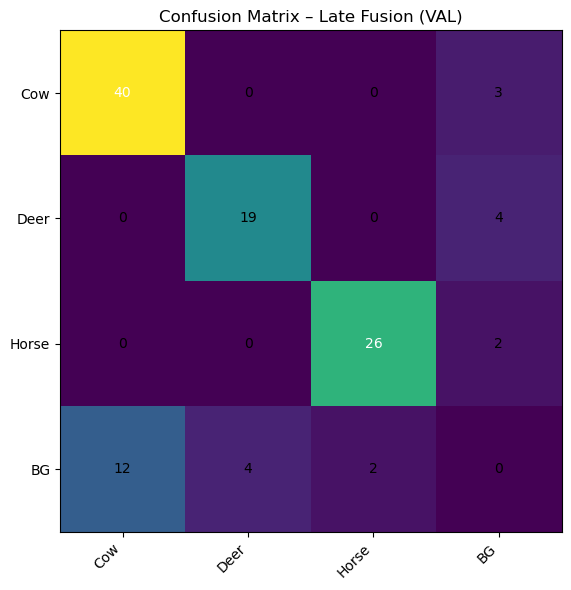

In [40]:
cm_lf_val = confusion_matrix_yolo(
    pred_dir=OUT_PRED_LF_VAL_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

plot_confusion_matrix(cm_lf_val, CLASS_LABELS + ["BG"], "Confusion Matrix – Late Fusion (VAL)")


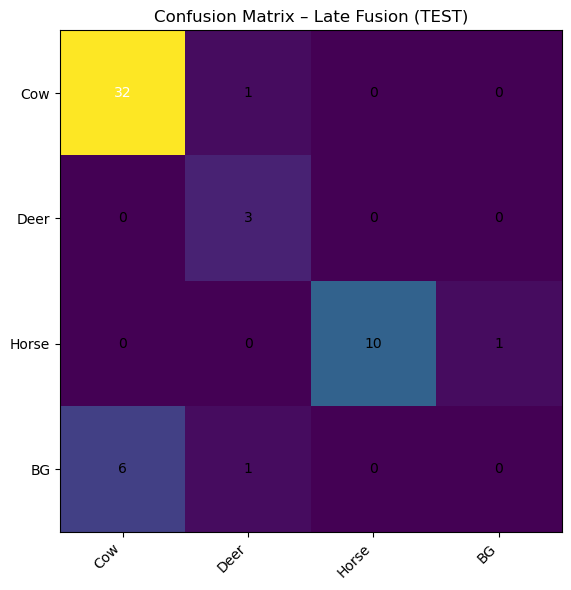

In [41]:
cm_lf_test = confusion_matrix_yolo(
    pred_dir=OUT_PRED_LF_TEST_DIR,
    gt_dir=GT_TEST_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5,
)

plot_confusion_matrix(cm_lf_test, CLASS_LABELS + ["BG"], "Confusion Matrix – Late Fusion (TEST)")
